In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

from ete3 import Tree#, NodeStyle, TreeStyle, TextFace


sns.set()
sns.set_style("ticks")

# UPGMA

In [3]:
def find_lowest_cell(table):
    x = 1
    y = 0
    min_val = table[x][y]
    for i in range(len(table)):
        for j in range(len(table[i])):
            if table[i][j] < min_val:
                min_val = table[i][j]
                x = i
                y = j
    return [x, y]

def link(x, y, wx, wy):
    return (x * wx + y * wy) / (wx + wy)

def update_table(table, a, b, weight_a, weight_b):
    for i in range(0, b):
        table[b][i] = link(table[b][i], table[a][i], weight_b, weight_a)
    for j in range(b+1, a):
        table[j][b] = link(table[j][b], table[a][j], weight_b, weight_a)
    for i in range(a+1, len(table)):
        table[i][b] = link(table[i][b], table[i][a], weight_b, weight_a)
    for i in range(a+1, len(table)):
        del table[i][a]
    del table[a] 

def update_labels(labels, i, j, di, dj):
    labels[j] = "({}:{},{}:{})".format(labels[j], dj, labels[i], di)
    del labels[i]

def upgma(mat, names):

    table = mat[:]
    labels = names[:]
    node_heights = [0 for _ in labels]

    while len(labels) > 1:
        i, j = find_lowest_cell(table)
        
        dist = table[i][j]

        wi = max(1, labels[i].count(':'))
        wj = max(1, labels[j].count(':'))

        new_node_height = dist / 2
        di = new_node_height - node_heights[i]
        dj = new_node_height - node_heights[j]
        
        update_table(table, i, j, wi, wj)
        update_labels(labels, i, j, di, dj)
        node_heights[j] = new_node_height
        del node_heights[i]
        
    return labels[0] + ';'

## Distance matrix

In [4]:
def jc(seq1, seq2, case_sensitive=True):
    assert len(seq1) == len(seq2), (len(seq1), len(seq2))
    tot, diff = 0, 0
    for x, y in zip(seq1, seq2):
        if not case_sensitive:
            x, y = x.upper(), y.upper()
        if x in 'ATCG' and y in 'ATCG':
            if x != y:
                diff += 1
            tot += 1    
    if not tot:
        return np.nan
    elif diff:
        distance = -3/4 * math.log(1 - 4/3 * diff/tot)
    else:
        distance = 0.0
    return distance


def dist_matrix(seq_list, case_sensitive=True, dist_fun=jc):
    n = len(seq_list)
    mat = np.zeros((n, n))

    upper_trag_idx = list(zip(*np.triu_indices(n, k=1)))
#     seq_pairs = [(seq_list[i], seq_list[j]) for i, j in upper_trag_idx]
    args = [(seq_list[i], seq_list[j], case_sensitive) for i, j in upper_trag_idx]

    jc_distances = []
    for a, b, c in args:
        jc_distances.append(dist_fun(a, b, c))
    
    # with Pool(int(os.environ['SLURM_CPUS_PER_TASK'])) as p:
    #     jc_distances = p.starmap(dist_fun, args)

    for (i, j), d in zip(upper_trag_idx, jc_distances):
        mat[i][j] = d
        mat[j][i] = mat[i][j]

    return mat


def prune_nans(mat, name_list):

    # Find rows (and cols) where all off-diagonal entries are nan:
    mask = np.isnan(mat).sum(axis=0) == np.size(mat, axis=0)-1
    delete = [i for (i, delete) in enumerate(mask) if delete]
    # remove those rows and cols:
    mat = np.delete(mat, delete, axis=0)
    mat = np.delete(mat, delete, axis=1)
    # update name list:
    name_list = [name for (i, name) in enumerate(name_list) if i not in delete]
    
    # if there are any nans left we have to remove all row/cols with a nan:
    if np.isnan(mat).any():    
        # in that case we could do this to remove all row/cols with a nan
        mask = np.isnan(mat).sum(axis=0).astype('bool')
        delete = [i for (i, delete) in enumerate(mask) if delete]
        # remove those rows and cols:
        mat = np.delete(mat, delete, axis=0)
        mat = np.delete(mat, delete, axis=1)
        # update name list:
        name_list = [name for (i, name) in enumerate(name_list) if i not in delete]
        
    return mat, name_list

## Construct and manipulate tree

In [5]:
def tree_newick(name_list, seq_list, case_sensitive=True, dist_fun=jc):

    mat = dist_matrix(seq_list, case_sensitive=case_sensitive, dist_fun=dist_fun)
    mat, name_list = prune_nans(mat, name_list)
    
    lowtri = [lst[:i] for (i, lst) in enumerate(mat.tolist())]
    newick_str = upgma(lowtri, name_list)
    return newick_str

def order_tree(t, key=lambda c: len(c.get_leaves())):
    """
    without key for sorting it makes a comb tree by default
    """
    for node in t.traverse():
        if not node.is_leaf():
            node.children = sorted(node.children, key=key, reverse=False)

def remove_outgroup(name):
    tree.set_outgroup( tree&name )
    all_leaves = tree.get_leaf_names()
    all_leaves.remove(name)
    tree.prune(all_leaves, preserve_branch_length=False)


# # remove chimp outgroup branches
# tree.set_outgroup( tree&"Outgroup" )
# all_leaves = tree.get_leaf_names()
# all_leaves.remove('Outgroup')
# tree.prune(all_leaves, preserve_branch_length=False)

In [6]:
def plot_tree(t, ax, leaf_colors=None, show_inner_nodes=False, fontsize=10, 
              text_offset=None, margins=(0.5, 1, 0.5, 1)): # top, right, bottom, left

    y_offset = len(t.get_leaves())
    for node in t.traverse("preorder"):
        node.x_offset = node.dist + sum(x.dist for x in node.get_ancestors())
        if node.is_leaf():
            y_offset -= 1
            node.y_offset = y_offset

    for node in t.traverse("postorder"):
        if not node.is_leaf():
            node.y_offset = sum(x.y_offset for x in node.children) / len(node.children)

    horizontal_lines = list()
    vertical_lines = list()
    node_coords = list()
    leaf_coords = list()
    max_x_offset = 0
    for node in t.traverse("postorder"):
        max_x_offset = max(max_x_offset, node.x_offset)
        node_coords.append((node.x_offset, node.y_offset))
        if node.is_leaf():
            leaf_coords.append([node.name, node.x_offset, node.y_offset])
        if not node.is_root():
            y = node.y_offset
            horizontal_lines.append(([node.up.x_offset, node.x_offset], [y, y]))
        if not node.is_leaf():
            c = sorted(node.children, key=lambda x: x.y_offset)
            bottom, top = c[0], c[-1]
            x = node.x_offset
            vertical_lines.append(([x, x],[bottom.y_offset, top.y_offset]))

    
    # shift the tree to put leaves at zero
    for i in range(len(horizontal_lines)):
        horizontal_lines[i][0][0] -= max_x_offset
        horizontal_lines[i][0][1] -= max_x_offset
    for i in range(len(vertical_lines)):
        vertical_lines[i][0][0] -= max_x_offset
        vertical_lines[i][0][1] -= max_x_offset
    for i in range(len(leaf_coords)):
        leaf_coords[i][1] -= max_x_offset
            
    # draw the tree:
    for x in horizontal_lines:
        ax.plot(*x, c='black', linewidth=0.8)
    for x in vertical_lines:
        ax.plot(*x, c='black', linewidth=0.8)

#     for tup in node_coords:
#         ax.plot(*tup, c='black', marker="o")

    if text_offset is None:
        text_offset = max_x_offset / 20
        
    for name, x, y in leaf_coords:
        ax.text(x+text_offset, y, name, fontsize=fontsize,
                verticalalignment='center', horizontalalignment='left')
        if leaf_colors is None:
            color = 'black'
        else:
            color = leaf_colors[name]
        ax.plot(x, y, c=color, marker="o", ms=3)


#     ax.set_xlim(-margins[3], max_x_offset + margins[1])
    ax.set_xlim(-margins[3]-max_x_offset, margins[1])
    ax.set_ylim(-margins[2], len(leaf_coords)-1+margins[0])


    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['right'].set_visible(False)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
    return leaf_coords

['sample0', 'sample1', 'sample2', 'sample3', 'sample4'] ...
[[0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [1 0 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


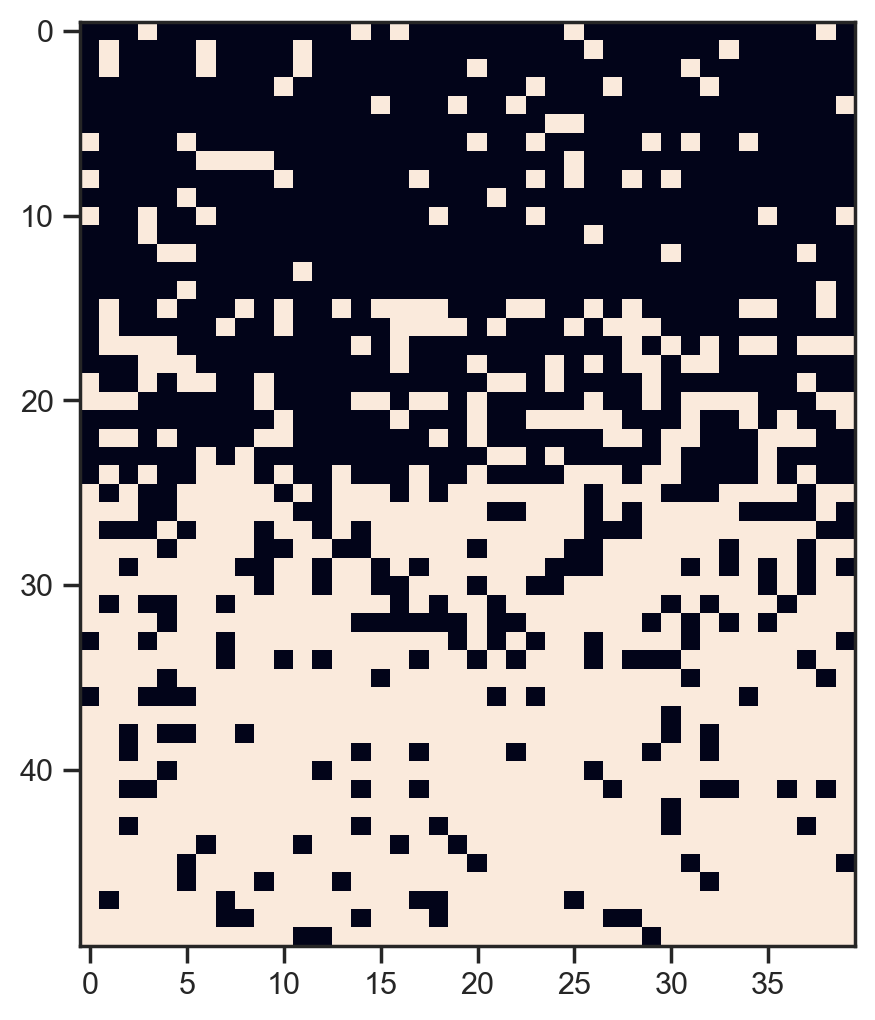

In [31]:
sample_name_list = [f'sample{i}' for i in range(50)]
seq_window_list = np.concatenate([np.random.choice([0, 1], size=600, p=[0.9, 0.1]).reshape(15, -1), 
                                  np.random.choice([0, 1], size=400, p=[0.7, 0.3]).reshape(10, -1),                                  
                                  np.random.choice([0, 1], size=400, p=[0.3, 0.7]).reshape(10, -1),
                                  np.random.choice([0, 1], size=600, p=[0.1, 0.9]).reshape(15, -1)])
print(sample_name_list[:5], '...')
print(seq_window_list)
plt.figure(figsize=(5, 6))
plt.imshow(seq_window_list, aspect='auto') ;

Index of sorted haplotypes: [13, 5, 9, 14, 11, 12, 0, 3, 4, 7, 1, 2, 23, 10, 6, 8, 19, 18, 21, 16, 17, 22, 24, 15, 20, 32, 26, 29, 30, 27, 34, 28, 25, 31, 33, 36, 41, 39, 48, 47, 43, 38, 46, 45, 44, 35, 49, 40, 37, 42]


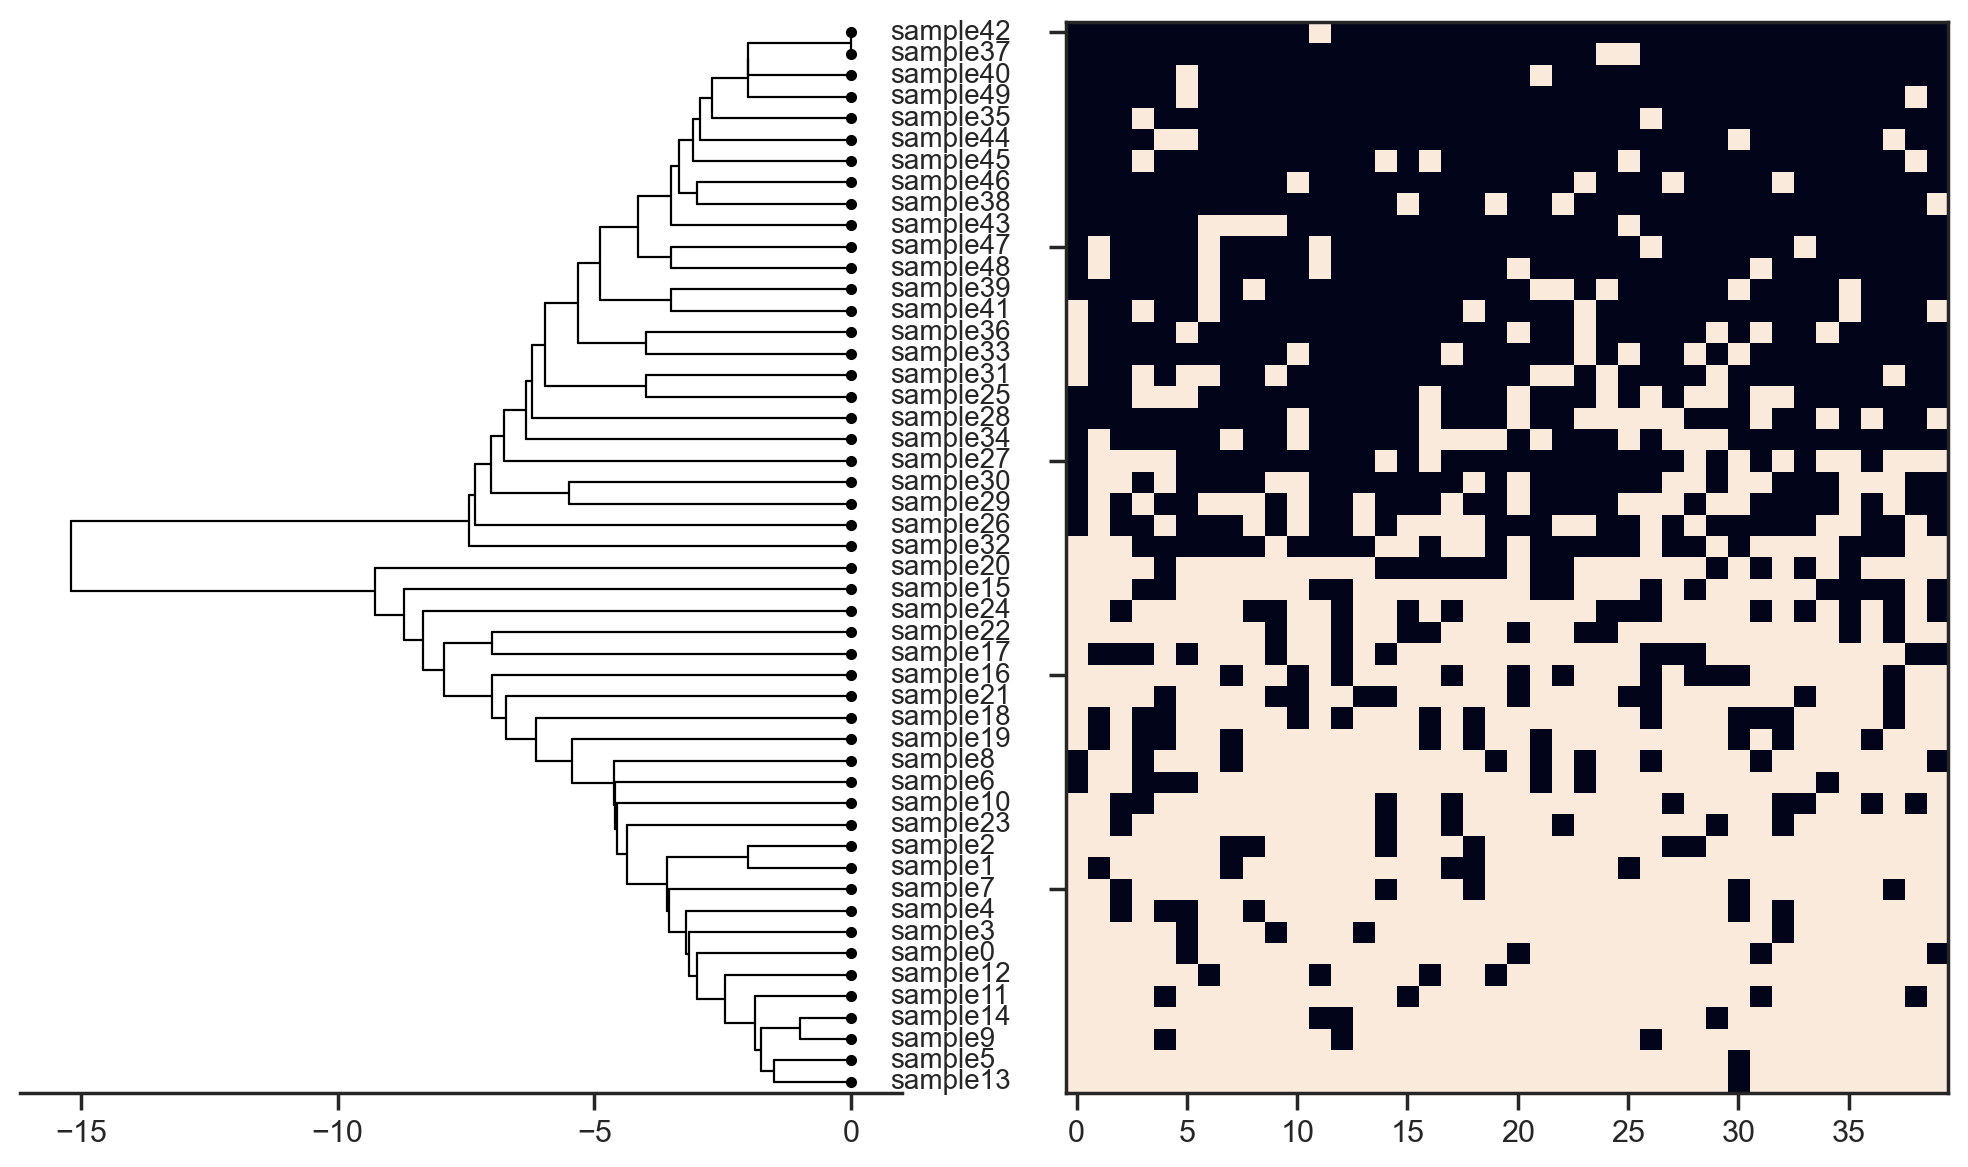

In [32]:

    
def proportion_same_ancestry(*args):
    a, b, case_sensitive = args
    "a and b are arrays or seris of posterior probabilities of minor parent ancestry"
    return np.absolute(a.round() - b.round()).sum()

newick_str = tree_newick(sample_name_list, seq_window_list, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

def order_fun(c):
    leaf_names = [x.name for x in c.get_leaves()]
    idx = [sample_name_list.index(x) for x in leaf_names]
    return seq_window_list[idx].mean()

order_tree(tree, key=order_fun)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

leaf_info = plot_tree(tree, ax1, fontsize=10)
names, x, y = zip(*leaf_info)
idx = [sample_name_list.index(x) for x in names]

print("Index of sorted haplotypes:", idx)

sorted_seq_window_list = np.array([seq_window_list[i] for i in idx])
ax2.imshow(sorted_seq_window_list, aspect='auto') ;
ax2.invert_yaxis()
plt.tight_layout()

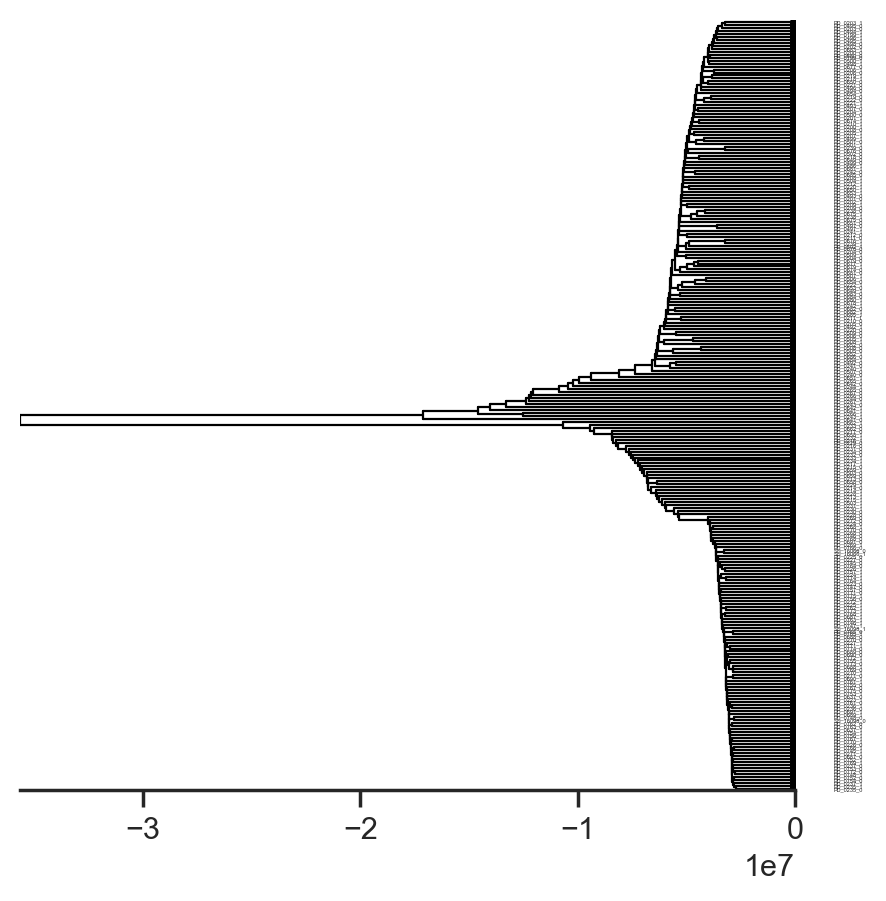

In [84]:
df = pd.read_csv('chr20_test.txt')

df['chrom'] = 'chrX'
df['pop'] = df.haplo_ID
df['is_north'] = (df.north == 1).astype(int)
df['is_south'] = (df.north == -1).astype(int)
df = df.sort_values(['pop', 'chrom', 'start'])

haplo_ID_list = list(df.haplo_ID.unique())

north_south_segment_lists = []
for sample_name in haplo_ID_list:
    north_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 1), ['pos', 'end_pos']].itertuples(index=False, name=None))
    south_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 0), ['pos', 'end_pos']].itertuples(index=False, name=None))
    north_south_segment_lists.append((north_tuples, south_tuples))

def tot_overlap(arr1, arr2):
    """total overlap of two lists of intervals"""
    tot = 0
    i = j = 0
    n = len(arr1)
    m = len(arr2)
    while i < n and j < m:
        l = max(arr1[i][0], arr2[j][0])
        r = min(arr1[i][1], arr2[j][1])
        if l <= r: 
            tot += r - l
        if arr1[i][1] < arr2[j][1]:
            i += 1
        else:
            j += 1
    return tot

def proportion_same_ancestry(*args):
    """proportion of chromsome with same ancestry"""
    a, b, case_sensitive = args
    ovl = tot_overlap(a[0], b[0]) + tot_overlap(a[1], b[1])
    return 77000000 - ovl
    
newick_str = tree_newick(haplo_ID_list, north_south_segment_lists, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

def order_fun(c):
    """order child clades so that leaves in left has more north ancestry"""
    leaf_names = [x.name for x in c.get_leaves()]
    idx = [haplo_ID_list.index(x) for x in leaf_names]
    return sum(e-s for i in idx for (s, e) in north_south_segment_lists[i][1]) - sum(e-s for i in idx for (s, e) in north_south_segment_lists[i][0])

order_tree(tree, key=order_fun)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

leaf_info = plot_tree(tree, ax1, fontsize=2)
haplo_ID_sorting, x, y = zip(*leaf_info)

/Users/kmt/miniconda3/envs/baboons/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/kmt/miniconda3/envs/baboons/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/kmt/miniconda3/envs/baboons/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


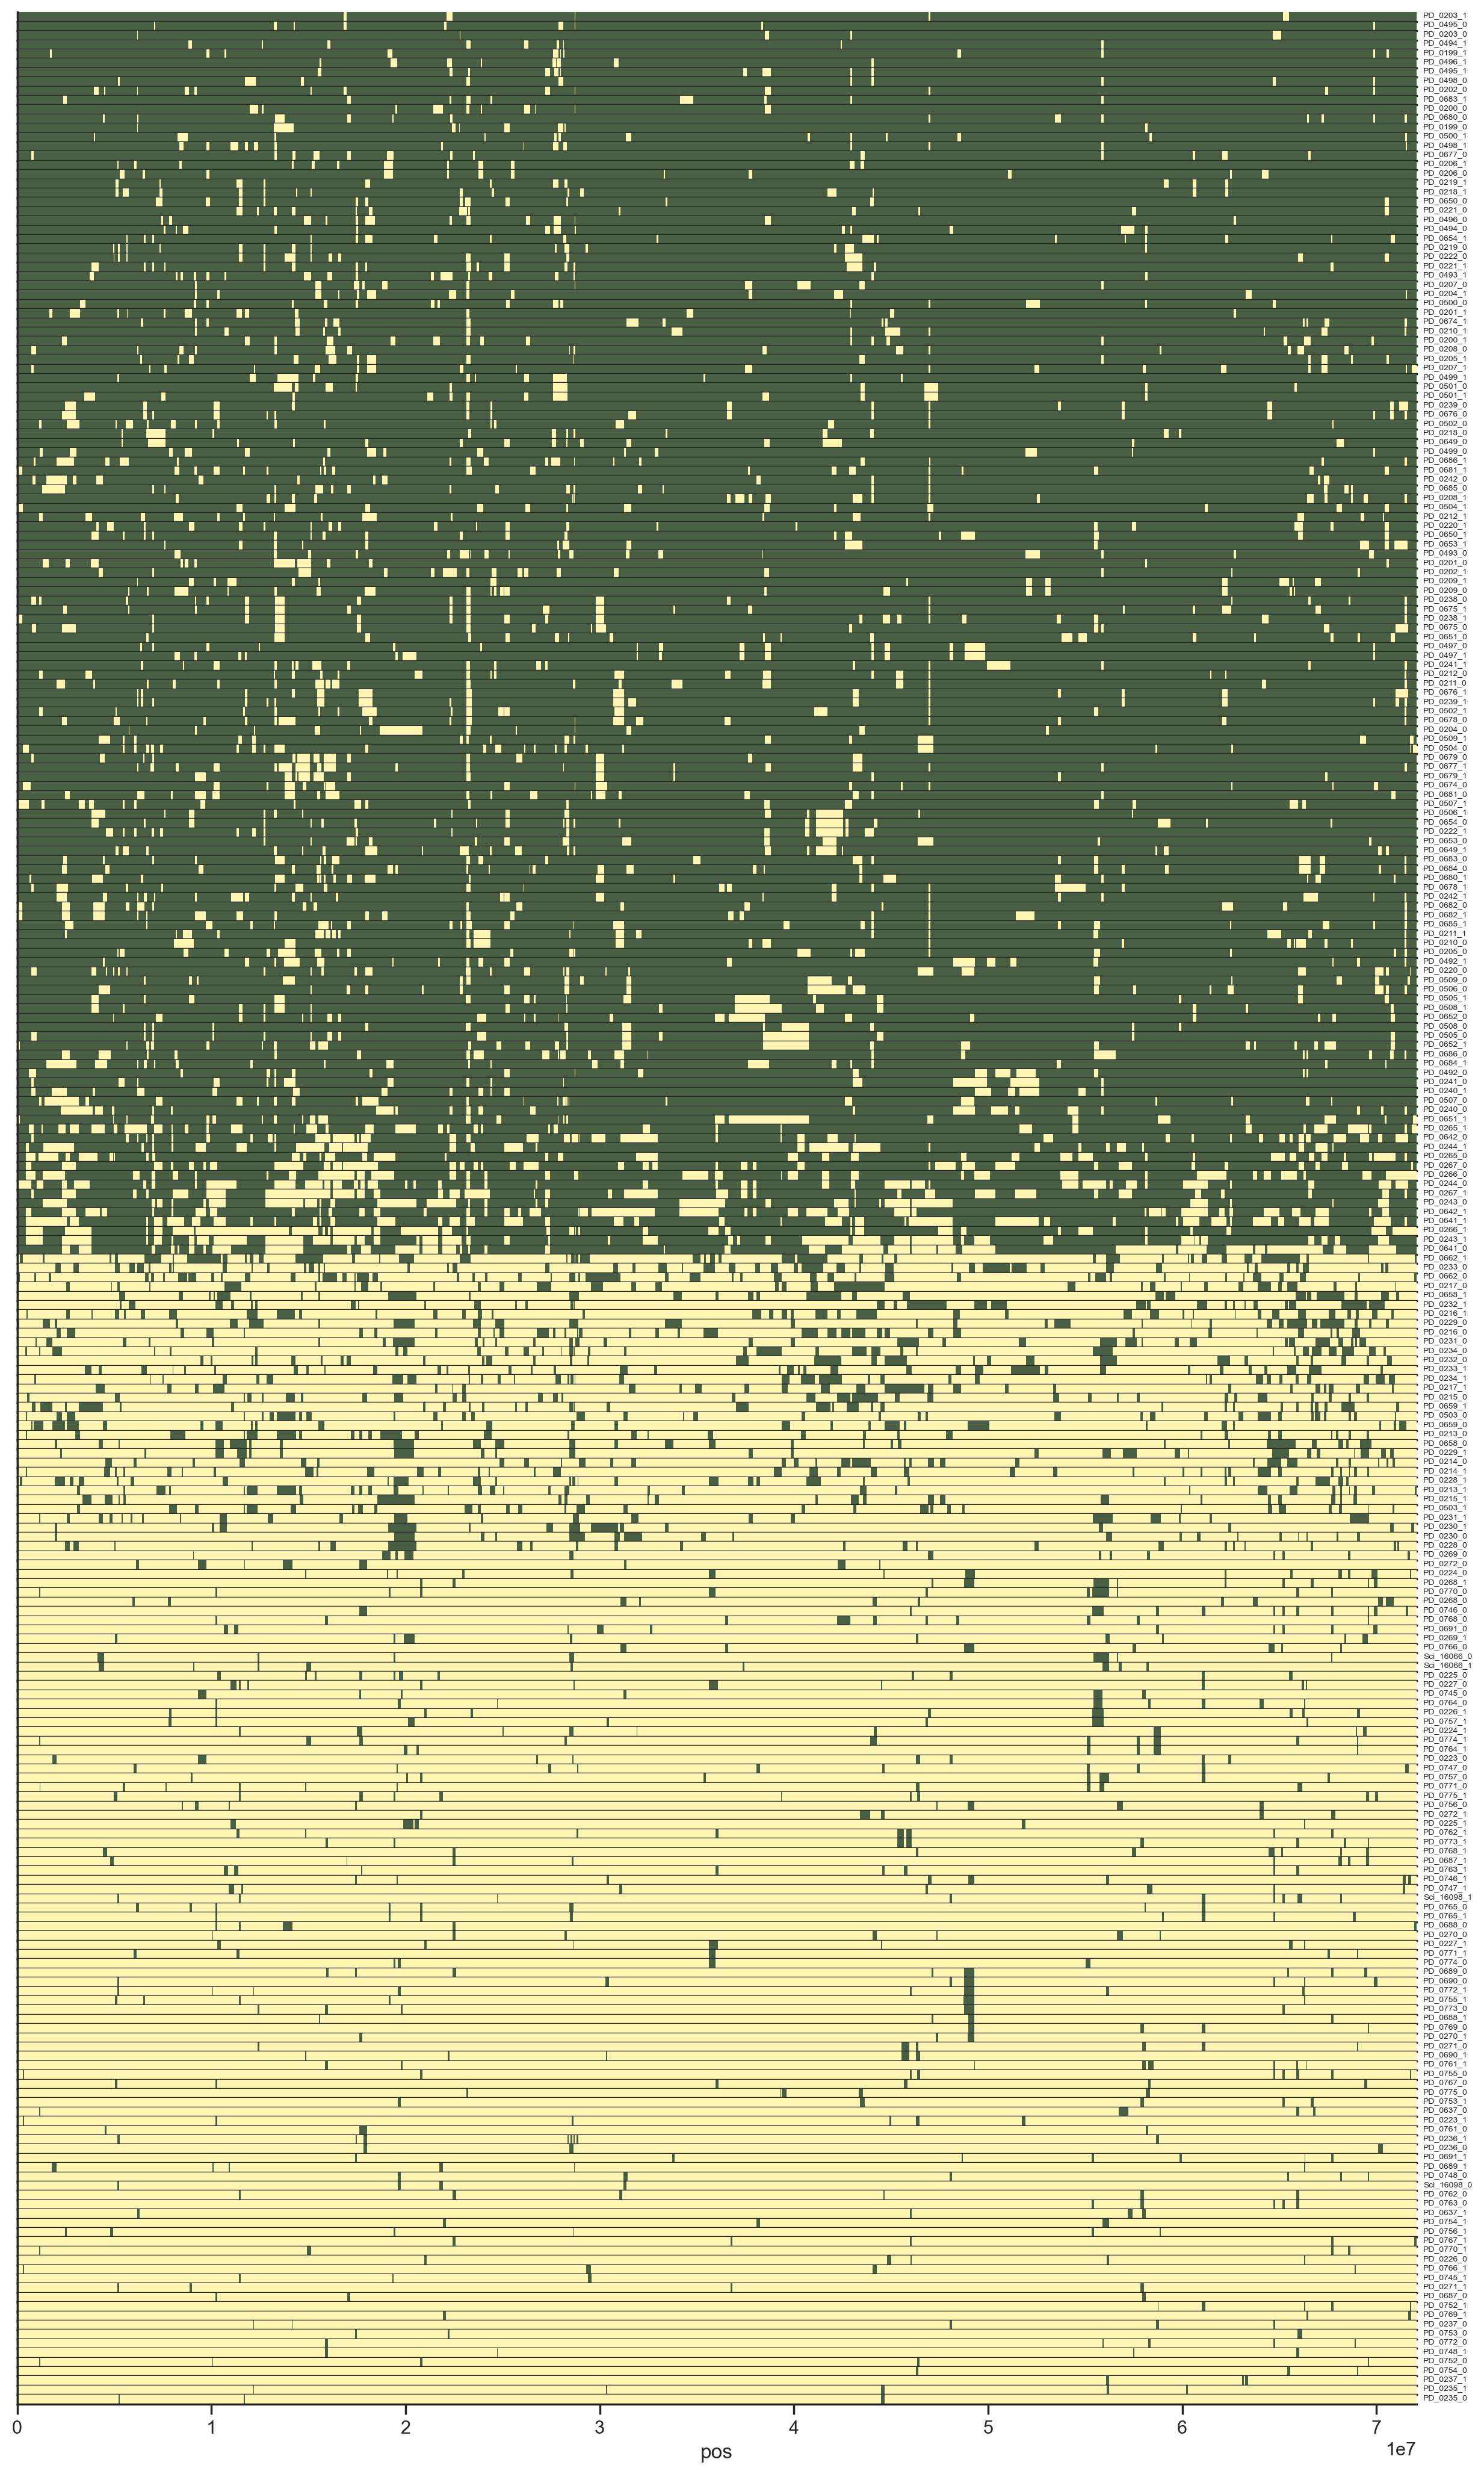

In [85]:
def stairs(df, start='pos', end='end_pos', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

g = sns.FacetGrid(stairs(df), col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.1, aspect=150,
                    row_order=haplo_ID_sorting, margin_titles=True, gridspec_kws={'hspace':0.0})
g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color='#495F43',
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color='#FFF6B4',
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(hap_sorting, g.axes.flat):
    ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))